In [69]:
library(dplyr)
library(ggplot2)
library(ROCR)

In [70]:
# Load the data
data <- read.csv("cleaned_data.csv", stringsAsFactors = TRUE)

# Check the structure of the data
str(data)

'data.frame':	1205 obs. of  15 variables:
 $ X                  : int  1 2 3 4 5 6 7 8 9 10 ...
 $ gender             : Factor w/ 2 levels "Boy","Girl": 1 2 2 2 2 1 1 1 1 1 ...
 $ education_level    : Factor w/ 3 levels "College","School",..: 3 3 1 2 2 2 2 2 1 2 ...
 $ institution_type   : Factor w/ 2 levels "Government","Non Government": 2 2 1 2 2 2 2 2 1 2 ...
 $ it_student         : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ location           : Factor w/ 2 levels "No","Yes": 2 2 2 2 2 2 2 2 2 2 ...
 $ load_shedding      : Factor w/ 2 levels "High","Low": 2 1 2 2 2 2 2 2 2 2 ...
 $ financial_condition: Factor w/ 3 levels "Mid","Poor","Rich": 1 1 1 1 2 2 1 1 1 1 ...
 $ internet_type      : Factor w/ 2 levels "Mobile Data",..: 2 1 2 1 1 1 2 2 2 1 ...
 $ network_type       : Factor w/ 3 levels "2G","3G","4G": 3 3 3 3 2 2 3 3 3 2 ...
 $ class_duration     : Factor w/ 3 levels "0","1-3","3-6": 3 2 2 2 1 2 1 2 2 2 ...
 $ self_lms           : Factor w/ 2 levels "No","Yes": 1

In [71]:
# Create the three engineered variables: digital_literacy, socio_economic_status, and access_score

# 1. Digital Literacy (categorical)
data$digital_literacy <- ifelse(data$device == "Computer" & data$it_student == "Yes", "High", "Low")
data$digital_literacy <- as.factor(data$digital_literacy)

# 2. Socio-Economic Status (categorical)
data$socio_economic_status <- case_when(
  data$financial_condition == "Rich" & data$education_level == "College" ~ "High",
  data$financial_condition == "Mid" & data$education_level == "School" ~ "Medium",
  data$financial_condition == "Poor" & data$education_level == "School" ~ "Low",
  TRUE ~ "Other" # For combinations not explicitly covered.
)
data$socio_economic_status <- as.factor(data$socio_economic_status)

# 3. Access Score (numerical)
# Assign numerical values to each level of the variables
location_score <- ifelse(data$location == "Yes", 1, 0)
load_shedding_score <- ifelse(data$load_shedding == "Low", 1, 0)
internet_type_score <- ifelse(data$internet_type == "Wifi", 1, 0)

network_score <- case_when(
  data$network_type == "4G" ~ 3,
  data$network_type == "3G" ~ 2,
  data$network_type == "2G" ~ 1,
  TRUE ~ 0
)

# Calculate the access score
data$access_score <- location_score + load_shedding_score + internet_type_score + network_score

# Check the new variables
head(data[, c("digital_literacy", "socio_economic_status", "access_score")])


,digital_literacy,socio_economic_status,access_score
,<fct>,<fct>,<dbl>
1,Low,Other,6
2,Low,Other,4
3,Low,Other,6
4,Low,Medium,5
5,Low,Low,4
6,Low,Low,4


In [72]:
# Create binary adaptivity variable where "Moderate" and "High" are both considered high (1)
data$high_adaptivity <- ifelse(data$adaptivity_level %in% c("Moderate", "High"), 1, 0)
data$high_adaptivity <- as.factor(data$high_adaptivity)

# Check the new variable
table(data$high_adaptivity)


  0   1 
480 725 


High  Low 
 118 1087 


  High    Low Medium  Other 
     2    143    336    724 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    4.00    5.00    4.66    6.00    6.00 

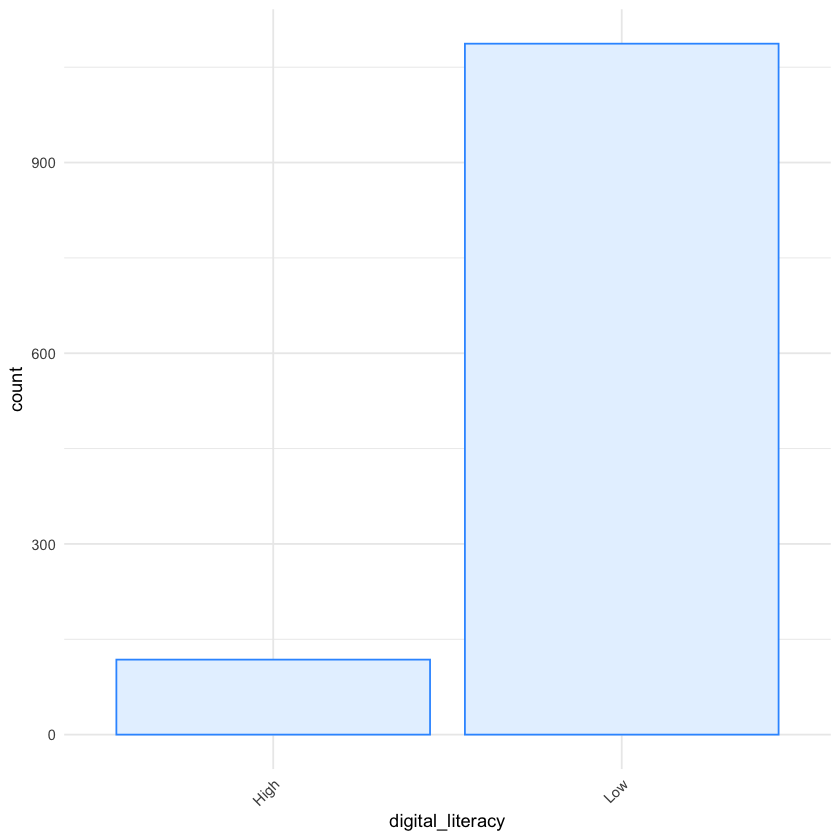

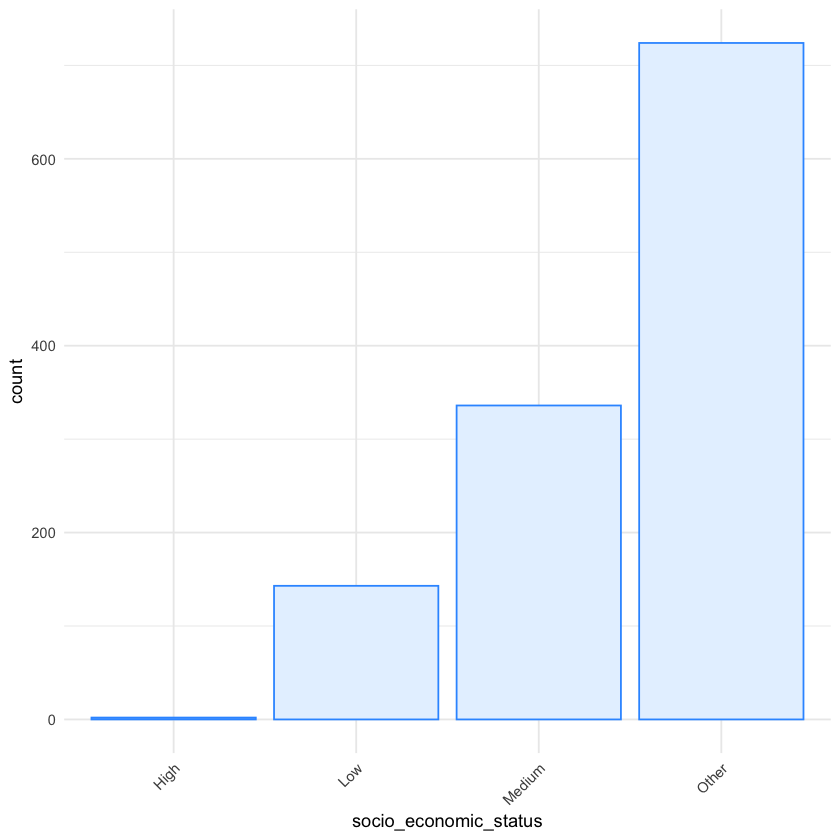

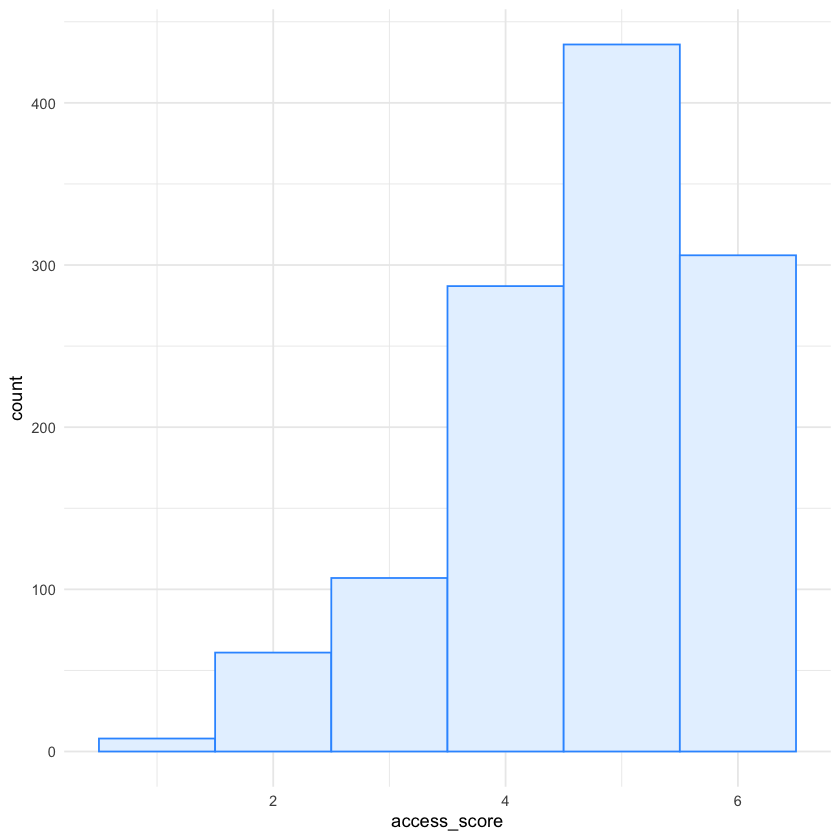

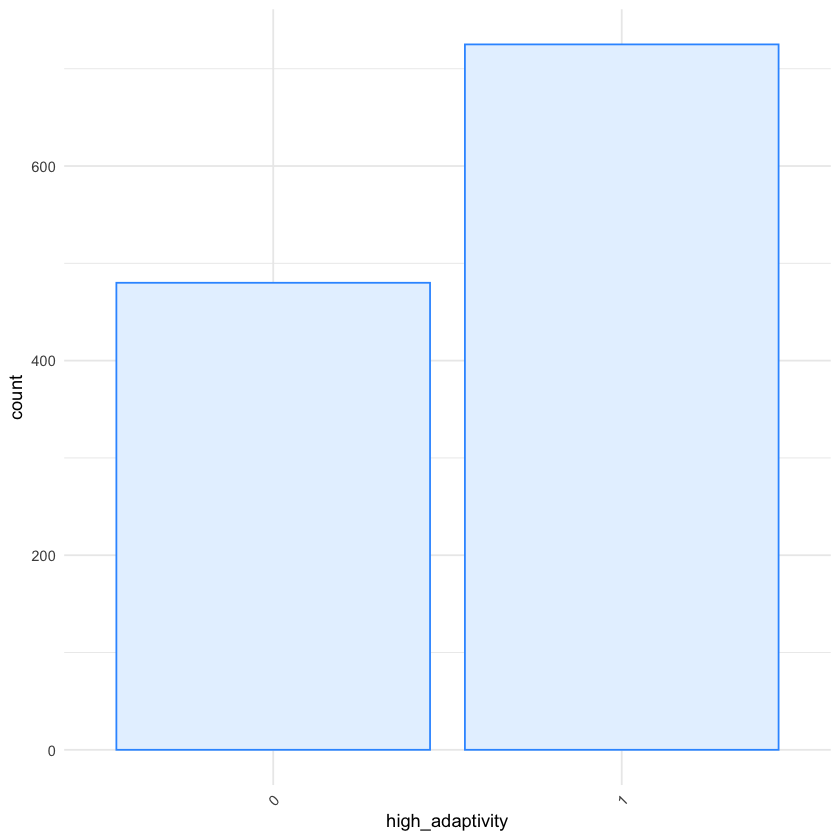

In [73]:
# Initial Data Exploration: Check the distributions of the engineered variables
# Check distributions
table(data$digital_literacy)
table(data$socio_economic_status)
summary(data$access_score)

# Visualize distributions with a more professional color palette
ggplot(data, aes(x = digital_literacy)) + 
  geom_bar(fill = "#e6f2ff", color = "#3399ff") + 
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggplot(data, aes(x = socio_economic_status)) + 
  geom_bar(fill = "#e6f2ff", color = "#3399ff") + 
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggplot(data, aes(x = access_score)) + 
  geom_histogram(binwidth = 1, fill = "#e6f2ff", color = "#3399ff") + 
  theme_minimal()

ggplot(data, aes(x = high_adaptivity)) + 
  geom_bar(fill = "#e6f2ff", color = "#3399ff") + 
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [74]:
# Statistical Analysis
# Examine the associations between our categorical engineered variables (digital_literacy, socio_economic_status) and our target variable (high_adaptivity)
# using Fischer's Exact Test due to the low expected frequecy in contingency table and low sample size.

# Fisher's Exact Test for digital literacy vs. high adaptivity
fisher_digital_literacy <- fisher.test(table(data$digital_literacy, data$high_adaptivity))
print(fisher_digital_literacy)

# Fisher's Exact Test for socio-economic status vs. high adaptivity
fisher_socio_economic <- fisher.test(table(data$socio_economic_status, data$high_adaptivity))
print(fisher_socio_economic)




	Fisher's Exact Test for Count Data

data:  table(data$digital_literacy, data$high_adaptivity)
p-value = 0.001472
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3190178 0.7867605
sample estimates:
odds ratio 
 0.5065831 


	Fisher's Exact Test for Count Data

data:  table(data$socio_economic_status, data$high_adaptivity)
p-value = 6.362e-07
alternative hypothesis: two.sided



In [75]:
# Logistic Regression
# Run the logistic regression model to predict high_adaptivity based on digital_literacy, socio_economic_status, and access_score.

# Run logistic regression model
model <- glm(high_adaptivity ~ digital_literacy + socio_economic_status + access_score, data = data, family = binomial)

# Summary of the model
summary(model)

# Odds ratios
odds_ratios <- exp(coef(model))
print(odds_ratios)



Call:
glm(formula = high_adaptivity ~ digital_literacy + socio_economic_status + 
    access_score, family = binomial, data = data)

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -14.56790  378.59305  -0.038  0.96931    
digital_literacyLow          -0.63740    0.22934  -2.779  0.00545 ** 
socio_economic_statusLow     13.61863  378.59291   0.036  0.97130    
socio_economic_statusMedium  14.53116  378.59289   0.038  0.96938    
socio_economic_statusOther   13.92553  378.59288   0.037  0.97066    
access_score                  0.32785    0.05449   6.017 1.78e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1620.3  on 1204  degrees of freedom
Residual deviance: 1537.9  on 1199  degrees of freedom
AIC: 1549.9

Number of Fisher Scoring iterations: 12


                (Intercept)         digital_literacyLow 
               4.712405e-07                5.286663e-01 
   socio_economic_statusLow socio_economic_statusMedium 
               8.212921e+05                2.045513e+06 
 socio_economic_statusOther                access_score 
               1.116300e+06                1.387975e+00 


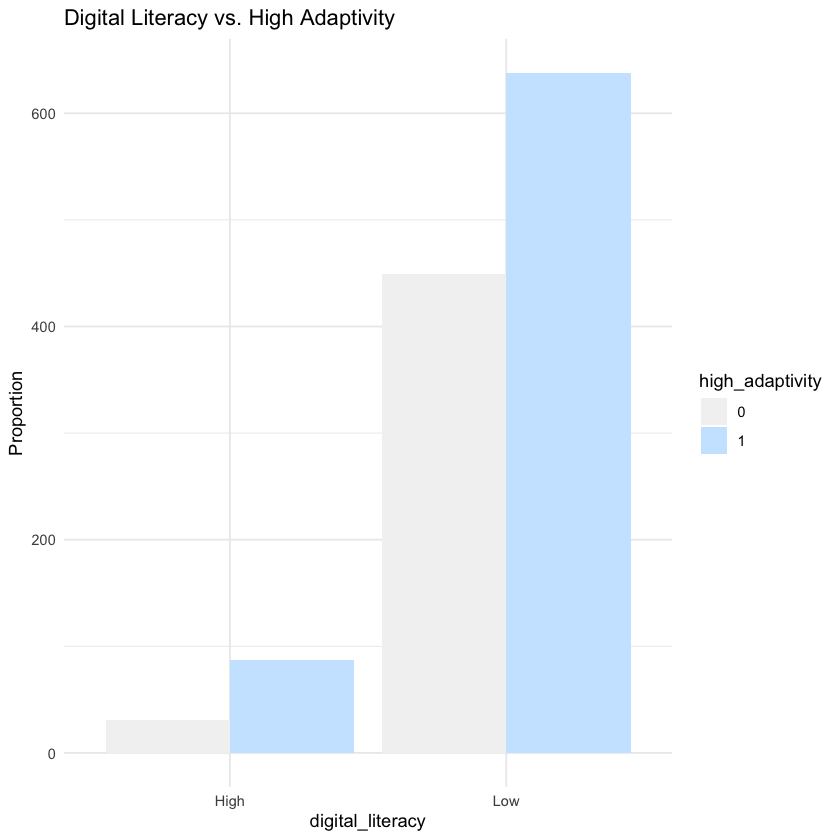

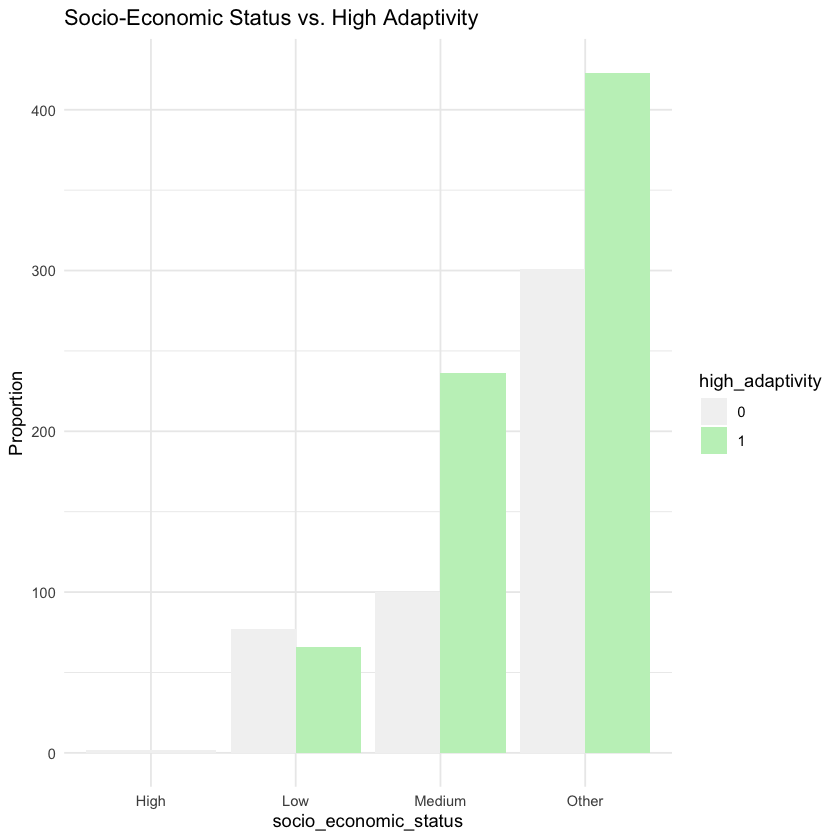

In [76]:
# Create bar plots to visualize the relationships between the categorical variables and high_adaptivity

# Bar plot for digital literacy vs. high adaptivity
ggplot(data, aes(x = digital_literacy, fill = high_adaptivity)) +
  geom_bar(position = "dodge") +
  scale_fill_manual(values = c("#f2f2f2", "#cce6ff")) + # Set colors
  labs(title = "Digital Literacy vs. High Adaptivity", y = "Proportion") +
  theme_minimal() # Add minimal theme to make it look professional

# Bar plot for socio-economic status vs. high adaptivity
ggplot(data, aes(x = socio_economic_status, fill = high_adaptivity)) +
  geom_bar(position = "dodge") +
  scale_fill_manual(values = c("#f2f2f2", "#c2f0c2")) + # Set colors
  labs(title = "Socio-Economic Status vs. High Adaptivity", y = "Proportion") +
  theme_minimal() # Add minimal theme to make it look professional

      Predicted
Actual   0   1
     0 123 357
     1  87 638
[1] "AUC: 0.654899425287356"


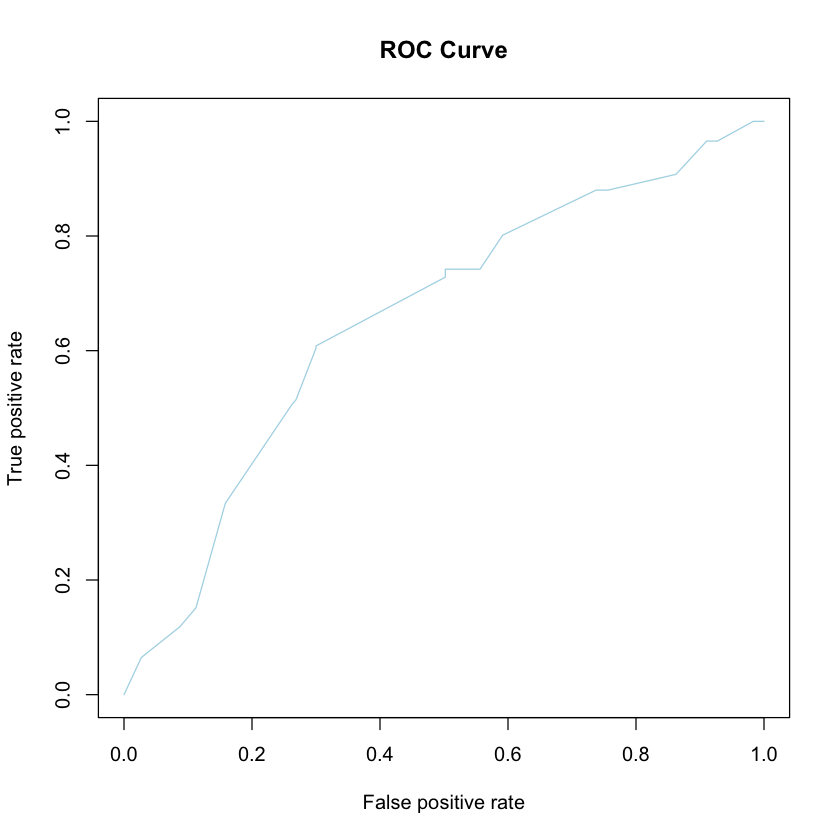

In [79]:
#  Evaluating the Model Performance: Evaluate the model's performance using metrics like:
# Confusion Matrix: To see how well the model predicts high_adaptivity.
# ROC Curve and AUC: To assess the model's ability to discriminate between the two classes

# Confusion Matrix
predicted_probabilities <- predict(model, type = "response")
predicted_classes <- ifelse(predicted_probabilities > 0.5, 1, 0)
confusion_matrix <- table(Actual = data$high_adaptivity, Predicted = predicted_classes)
print(confusion_matrix)

# ROC Curve and AUC
prediction <- prediction(predicted_probabilities, data$high_adaptivity)
performance <- performance(prediction, "tpr", "fpr")

# Plotting the ROC curve with light blue color
plot(performance, main = "ROC Curve", col = rgb(0.678, 0.847, 0.902))  # Light blue color
auc <- performance(prediction, "auc")
print(paste("AUC:", auc@y.values[[1]]))

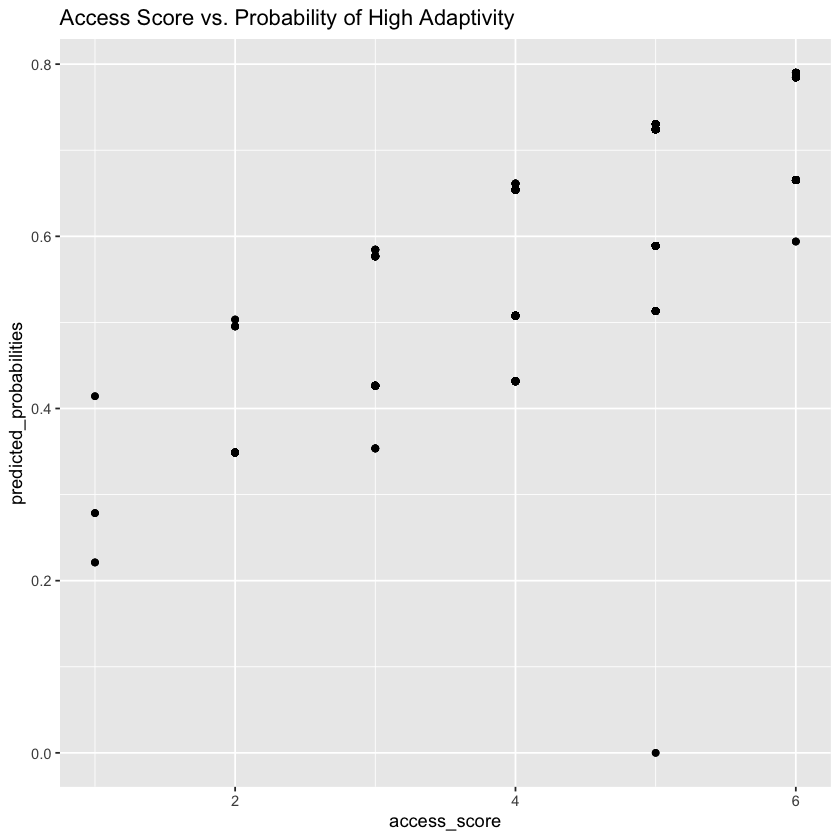

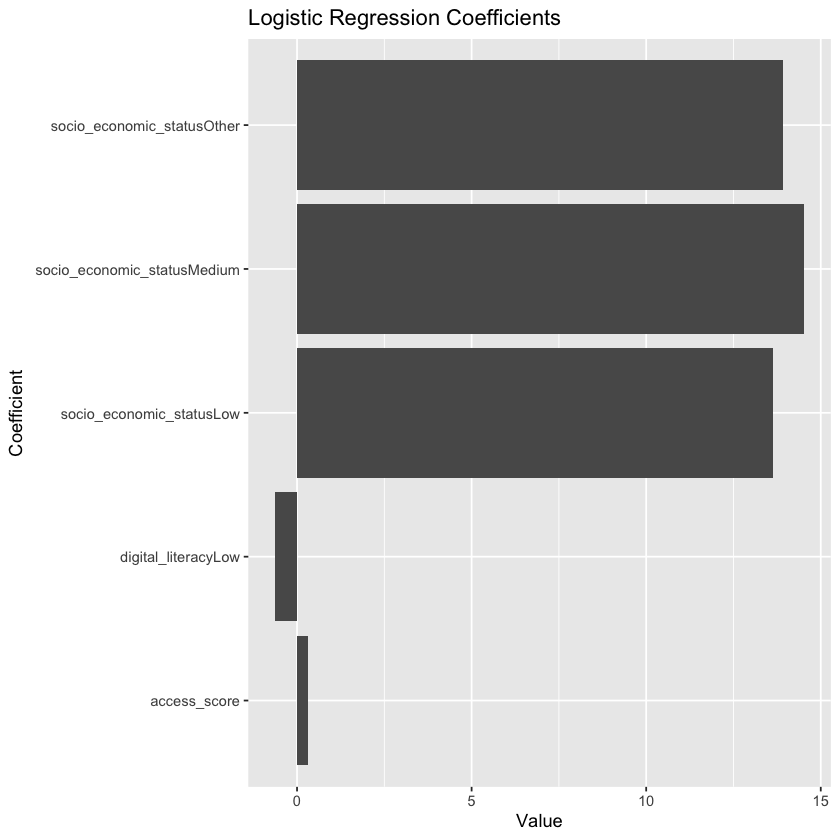

In [80]:
# Scatter Plot (Access Score vs. Probability)
ggplot(data, aes(x = access_score, y = predicted_probabilities)) +
  geom_point() +
  labs(title = "Access Score vs. Probability of High Adaptivity")

# Coefficient Plot
coef_data <- data.frame(Coefficient = names(coef(model)), Value = coef(model))
ggplot(coef_data[-1, ], aes(x = Coefficient, y = Value)) +
  geom_bar(stat = "identity") +
  labs(title = "Logistic Regression Coefficients") +
  coord_flip()